# Load Data

In [2]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
filepaths = glob.glob("../data/tidy/acetaminophen/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [4]:
apap_daily = df.resample("D").count()[["EVENT_ID"]]
apap_daily.columns = ["Doses"]

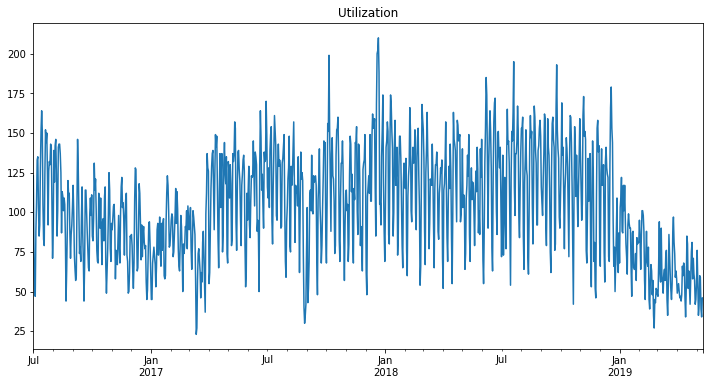

In [4]:
ax = apap_daily.plot(legend=False, figsize=(12, 6), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

# ACF

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

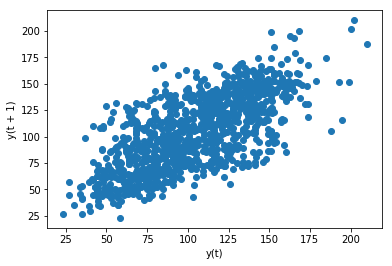

In [6]:
lag_plot(apap_daily["Doses"]);

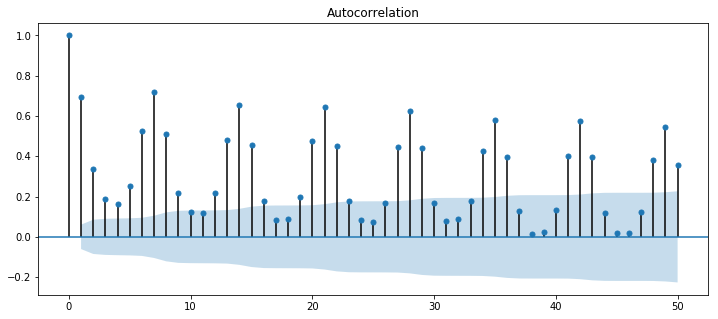

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

plot_acf(apap_daily["Doses"], lags=50, ax=ax);
#plot_acf(apap_daily);

In [8]:
# data is not stationary; p-value > 0.05
adfuller(apap_daily["Doses"].dropna(), autolag='AIC')[1]

0.2978121675515909

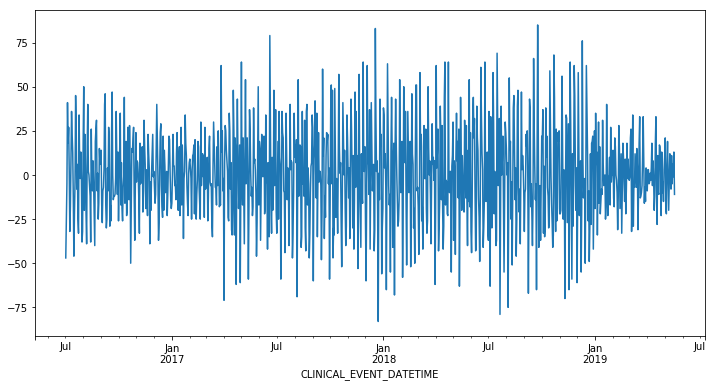

In [6]:
# difference the data to make it stationary
df_diff = apap_daily.copy()
df_diff["Doses"] = diff(apap_daily["Doses"], k_diff=1)
df_diff["Doses"].plot(figsize=(12, 6))

In [10]:
adfuller(df_diff["Doses"].dropna(), autolag='AIC')[1]

3.674029188920869e-19

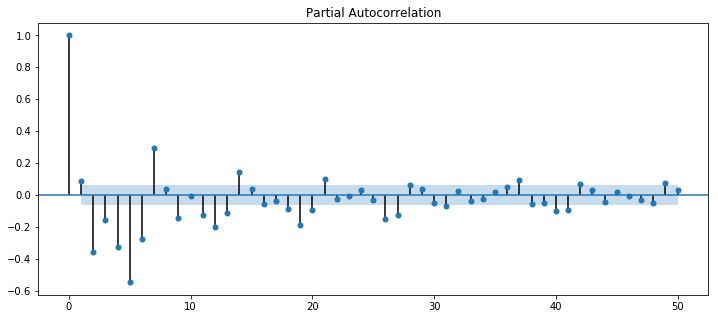

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Doses"].dropna(), lags=50, ax=ax);

# MLP

In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

Using TensorFlow backend.


In [7]:
n_inputs = 30
n_features = 1
n_valid = 7
n_pred = 30
batch_size = 16

In [8]:
df = apap_daily
#df = df_diff.dropna()
l = len(df) - n_pred
train_set = df.iloc[:l]
train = df.iloc[:l - n_valid]
valid = df.iloc[l - n_inputs - n_valid:l]
test_set = df.iloc[l:]

In [9]:
gen_train = TimeseriesGenerator(train["Doses"], train["Doses"], length=n_inputs, batch_size=batch_size)

In [10]:
gen_valid = TimeseriesGenerator(valid["Doses"], valid["Doses"], length=n_inputs, batch_size=batch_size)

In [11]:
#for i in range(len(gen_valid)):
#    x, y = gen_valid[i]
#    print('%s => %s' % (x, y))

In [12]:
n_nodes = int(len(apap_daily) / (2 * (n_inputs + n_features)))
n_nodes

16

In [23]:
#n_nodes = int(2/3 * (n_inputs + n_features))
#n_nodes

In [13]:
model = Sequential()
model.add(Dense(n_nodes, activation="relu", input_dim=n_inputs))
model.add(Dense(n_nodes, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit_generator(gen_train, epochs=300, validation_data=gen_valid)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
62/62 [==============================] - 2s 32ms/step - loss: 6815.3019 - val_loss: 319.8998
Epoch 2/300
62/62 [==============================] - 0s 6ms/step - loss: 967.4923 - val_loss: 289.1549
Epoch 3/300
62/62 [==============================] - 0s 7ms/step - loss: 895.3091 - val_loss: 270.2858
Epoch 4/300
62/62 [==============================] - 0s 7ms/step - loss: 834.4454 - val_loss: 246.8037
Epoch 5/300
62/62 [==============================] - 0s 7ms/step - loss: 794.1835 - val_loss: 231.1283
Epoch 6/300
62/62 [==============================] - 0s 7ms/step - loss: 740.9570 - val_loss: 251.8000
Epoch 7/300
62/62 [==============================] - 0s 7ms/step - loss: 706.3044 - val_loss: 205.0378
Epoch 8/300
62/62 [==============================] - 0s 7ms/step - loss: 676.3454 - val_loss: 218.6115
Epoch 9/300
62/62 [==============================] - 0s 7ms/step - loss: 628.3688 - val_loss: 190.7286
Epoch 10/300
62/62 [===

62/62 [==============================] - 0s 6ms/step - loss: 285.0203 - val_loss: 150.8027
Epoch 78/300
62/62 [==============================] - 0s 7ms/step - loss: 278.9205 - val_loss: 155.3822
Epoch 79/300
62/62 [==============================] - 0s 7ms/step - loss: 283.8890 - val_loss: 175.8645
Epoch 80/300
62/62 [==============================] - 0s 7ms/step - loss: 293.2997 - val_loss: 172.3286
Epoch 81/300
62/62 [==============================] - 0s 7ms/step - loss: 279.8573 - val_loss: 160.5385
Epoch 82/300
62/62 [==============================] - 0s 6ms/step - loss: 274.9893 - val_loss: 163.3409
Epoch 83/300
62/62 [==============================] - 0s 7ms/step - loss: 275.2649 - val_loss: 177.8181
Epoch 84/300
62/62 [==============================] - 0s 7ms/step - loss: 281.5776 - val_loss: 162.2518
Epoch 85/300
62/62 [==============================] - 0s 6ms/step - loss: 288.6579 - val_loss: 178.8890
Epoch 86/300
62/62 [==============================] - 0s 6ms/step - loss: 277

62/62 [==============================] - 0s 7ms/step - loss: 282.8071 - val_loss: 151.9707
Epoch 156/300
62/62 [==============================] - 0s 7ms/step - loss: 265.2926 - val_loss: 166.4478
Epoch 157/300
62/62 [==============================] - 0s 6ms/step - loss: 270.3106 - val_loss: 145.6652
Epoch 158/300
62/62 [==============================] - 0s 7ms/step - loss: 260.3769 - val_loss: 140.9626
Epoch 159/300
62/62 [==============================] - 0s 7ms/step - loss: 262.5448 - val_loss: 165.4764
Epoch 160/300
62/62 [==============================] - 0s 6ms/step - loss: 270.5447 - val_loss: 153.4275
Epoch 161/300
62/62 [==============================] - 0s 7ms/step - loss: 271.8946 - val_loss: 185.1895
Epoch 162/300
62/62 [==============================] - 0s 6ms/step - loss: 264.2516 - val_loss: 154.9669
Epoch 163/300
62/62 [==============================] - 0s 6ms/step - loss: 266.8687 - val_loss: 153.2371
Epoch 164/300
62/62 [==============================] - 0s 7ms/step - 

62/62 [==============================] - 0s 6ms/step - loss: 266.6673 - val_loss: 142.2336
Epoch 234/300
62/62 [==============================] - 0s 6ms/step - loss: 261.3265 - val_loss: 147.4712
Epoch 235/300
62/62 [==============================] - 0s 6ms/step - loss: 259.1680 - val_loss: 149.8848
Epoch 236/300
62/62 [==============================] - 0s 7ms/step - loss: 265.8318 - val_loss: 150.9604
Epoch 237/300
62/62 [==============================] - 0s 6ms/step - loss: 272.8517 - val_loss: 140.0261
Epoch 238/300
62/62 [==============================] - 0s 7ms/step - loss: 261.3616 - val_loss: 166.7624
Epoch 239/300
62/62 [==============================] - 0s 7ms/step - loss: 264.2582 - val_loss: 160.7462
Epoch 240/300
62/62 [==============================] - 0s 7ms/step - loss: 261.5351 - val_loss: 165.7872
Epoch 241/300
62/62 [==============================] - 0s 7ms/step - loss: 260.6656 - val_loss: 147.5308
Epoch 242/300
62/62 [==============================] - 0s 7ms/step - 

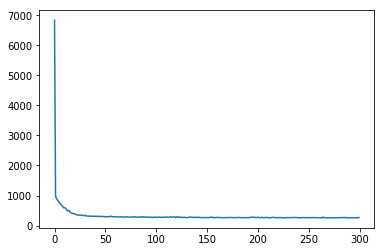

In [15]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [16]:
test_preds = []
first_batch = train_set[-n_inputs:]
current_batch = np.array(first_batch["Doses"]).reshape((1, n_inputs))

for i in range(len(test_set)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred[0])
    current_batch = np.append(current_batch[:, 1:], [current_pred], axis=1)

In [17]:
#true_preds = scaler.inverse_transform(test_preds)
test_set["Predictions"] = test_preds

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


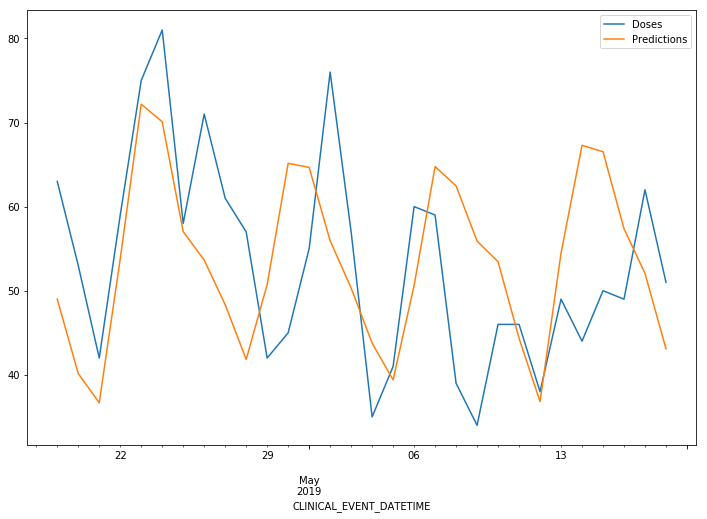

In [18]:
test_set.plot(figsize=(12, 8));

In [19]:
mse_rnn = mean_squared_error(test_set["Doses"], test_set["Predictions"])
rmse_rnn = rmse(test_set["Doses"],  test_set["Predictions"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN: 154.1690097
RMSE RNN: 12.41648137


# Forecast

In [20]:
n_fcast = 60
new_preds = []
first_batch = df[-n_inputs:]
current_batch = np.array(first_batch["Doses"]).reshape((1, n_inputs))

for i in range(n_fcast):
    current_pred = model.predict(current_batch)[0]
    new_preds.append(current_pred[0])
    current_batch = np.append(current_batch[:, 1:], [current_pred], axis=1)

In [21]:
#unscaled_preds = scaler.inverse_transform(new_preds)
#undiff_preds = apap_daily["Doses"].iloc[-1] + unscaled_preds.cumsum()
df_preds = pd.DataFrame(new_preds, columns=["Predictions"])
idx = pd.date_range(apap_daily.index[-1] + 1, periods = n_fcast, freq="D")
df_preds.index = idx

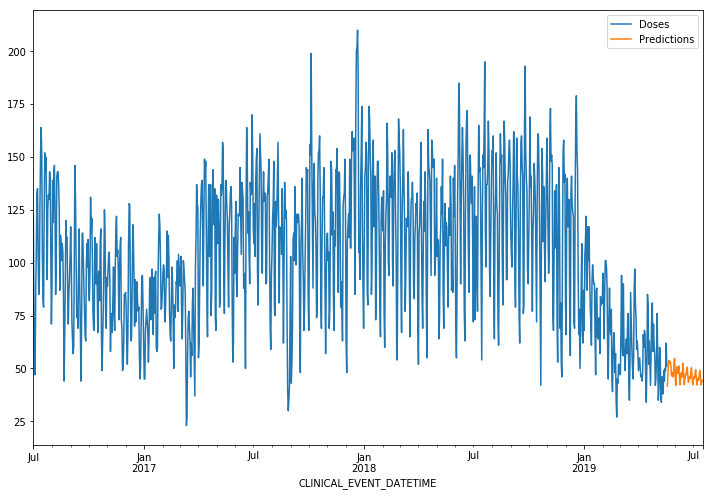

In [22]:
ax = apap_daily["Doses"].plot(figsize=(12, 8), legend=True)
df_preds["Predictions"].plot(legend=True);
ax.autoscale(axis='x',tight=True)

In [46]:
model.save("acetaminophen_mlp_2-layer.h5")